In [1]:
!pip install git+https://github.com/hajimes/mmh3
!pip install texttable
!pip install scipy
#для удобства сразу импортирую все необходимые библиотеки
import mmh3 # для вычисления хэша
from texttable import Texttable # для форматирования в виде таблиц
import uuid #для работы функций по генерации файлов
import random #для работы функций по генерации файлов
import math #для проверки размера HyperLogLog
from scipy.integrate import quad #для вычисления интеграла в HyperLogLog
from collections import Counter #для реализации HeavyHitters
import csv #для работы с csv-файлами

  Cloning https://github.com/hajimes/mmh3 to /tmp/pip-req-build-fqzhzrhv
  Running command git clone --filter=blob:none --quiet https://github.com/hajimes/mmh3 /tmp/pip-req-build-fqzhzrhv
  Resolved https://github.com/hajimes/mmh3 to commit bf1091d9d50892c8e5ae7e402b8fc077d0a6309e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mmh3: filename=mmh3-5.0.2.dev1-cp310-cp310-linux_x86_64.whl size=91096 sha256=81ad987e22e3c92f9ed3e0017198ab9fda3c4199c356170a318a6a880e1179aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7gil4ix/wheels/cf/79/44/adb27e35e7d5c3eb4d72aa5d607882d299c13158364c1d7fdd
Successfully built mmh3


**Вспомогательные функции**

In [4]:
def gen_uniq_seq(name, n_records, n_extra_cols=0):
    """
    Порождает файл с уникальными ключами в первом поле
    Можно заказать дополнительные колонки
    """
    with open(name, "wt") as f:
        for i in range(n_records):
            #if i % 1_000_000 == 0:
                #print(i)
            print(uuid.uuid4(), file=f, end="")
            for j in range(n_extra_cols):
                print(f",{uuid.uuid4()}", file=f, end="")
            print(file=f)

def gen_grouped_seq(name, pattern, *, n_extra_cols=0, to_shuffle=False):
    """
    Порождает файл с заданным шаблоном распределением повторяемости ключей в первом поле

    Шаблон - список пар положительных целых

    Первое число - сколько групп записей с заданной численностью хочется  породить
    Второй число - численность

    Проще объяснить на примерах:

    [(1, 1)] - хотим породить одну запись
    [(1, 100)] - хотим породить 100 записей с одним ключом
    [(100, 1)] - хотим породить 100 записей с разными ключами (100 групп записей численностью 1 каждая)
    [(15, 10)] - хотим породить 10 записей с одним ключом, 10 другим - и так 15 раз
    [(1000, 1), (2, 400)] - хотим породить 1000 записей с уникальными ключами, 400 записей с другим и еще 400 с каким-то еще

    Можно заказать дополнительные колонки

    По умолчанию ключи порождаются группами по порядку перебора элементов шаблона

    Если хочется перемешать, можно указать `to_shuffle=True`

    Но такое перемешивание предполагает накопление данных в памяти. И если хочется породить очень большой
    набор и перемешать записи - это не взлетит.

    На такой случай придумана функция `random_merge`. Создайте несколько перемешанных кусков в файлах, а потом смешайте
    """

    def gen():
        num = 0
        for n_keys, n_records in pattern:
            for i1 in range(n_keys):
                body = f"{i1 + num}:{uuid.uuid4()}"
                for i2 in range(n_records):
                    for j in range(n_extra_cols):
                        body += f",{uuid.uuid4()}"
                    yield body
            num += n_keys

    if to_shuffle:
        data = list(gen())
        random.shuffle(data)
        result = data
    else:
        result = gen()

    with open(name, "wt") as f:
        for v in result:
            print(v, file=f)

**Задание 1 - BloomFilter для одной хэш-функции**

Реализую BloomFilter через битовую арифметику над целыми числами. Класс будет состоять из следующих методов:

*   __init__ - конструктор класса: определяет значения фильтра и его размера;
*   __put__ - метод добавления очередной строки в BloomFilter: получаю позицию с помощью хэш-функции, использую битовый сдвиг и путем битового "ИЛИ" устанавливаю очередной бит в BloomFilter;
*   __get__ - метод получения строки из BloomFilter: с помощью "исключающего ИЛИ" проверяю, изменится ли фильтр после добавления строки: если да - значит изначально бит был нулевой (вхождения до настоящего момента не было, возвращаю False), иначе - True;
*   __size__ - метод получения числа единиц в фильтре: реализацию в цикле с побитовым сдвигом вправо и реализацией битового "И" по младшему разряду.





In [ ]:
class BloomFilter():

  def __init__(self, n):
    self.filterSize = n
    self.filter = 0

  def put(self, s):
    bitPosition = mmh3.hash(s) % self.filterSize
    self.filter |= 1 << bitPosition

  def get(self, s):
    bitPosition = mmh3.hash(s) % self.filterSize
    if (self.filter ^ (self.filter | 1 << bitPosition)) == 0:
      return True
    else:
      return False

  def size(self):
    size = 0
    while self.filter > 0:
      size += self.filter & 1
      self.filter = self.filter >> 1
    return size

Тестирование BloomFilter для одной хэш-функции (сократил максимальный размер, поскольку слишком долго отрабатывал код).

In [ ]:
#на самой большой паре за 4 часа не сработало, поэтому взял меньшие числа
uniqueStringSize = [5, 50, 500, 5000, 50000]
bloomFilterSize = [8, 64, 1024, 64000, 160000]

t = Texttable()
for i in uniqueStringSize:
  gen_uniq_seq("hw1_task1_file.txt", i)
  for j in bloomFilterSize:
    BF = BloomFilter(j)
    #обхожу файл построчно
    fpCount = 0
    with open("hw1_task1_file.txt") as f:
      for line in f:
        if BF.get(line) == True:
          fpCount += 1
        BF.put(line)
    f.close()
    t.add_rows([['bfSize', 'setSize', 'fpCount', 'onesCount'], [j, i, fpCount, BF.size()]])
print(t.draw())

+--------+---------+---------+-----------+
| bfSize | setSize | fpCount | onesCount |
+========+=========+=========+===========+
| 8      | 5       | 1       | 4         |
+--------+---------+---------+-----------+
| 64     | 5       | 0       | 5         |
+--------+---------+---------+-----------+
| 1024   | 5       | 0       | 5         |
+--------+---------+---------+-----------+
| 64000  | 5       | 0       | 5         |
+--------+---------+---------+-----------+
| 160000 | 5       | 0       | 5         |
+--------+---------+---------+-----------+
| 8      | 50      | 42      | 8         |
+--------+---------+---------+-----------+
| 64     | 50      | 18      | 32        |
+--------+---------+---------+-----------+
| 1024   | 50      | 3       | 47        |
+--------+---------+---------+-----------+
| 64000  | 50      | 0       | 50        |
+--------+---------+---------+-----------+
| 160000 | 50      | 0       | 50        |
+--------+---------+---------+-----------+
| 8      | 

Выводы:
1.   Можно заметить, что fpCount + onesCount = setSize, что в целом логично, поскольку записи, которые не изменили количество единиц в битовой записи, получили True при проверке нахождения в фильтре.
2.   По сути fpCount отражает число коллизий, т.к. на вход подавались все уникальные записи.
3.   Можно заметить, что в зависимости от соотношения размера фильтра и количества строк число коллизий меняется: если количество строк больше размера фильтра, то мы неизбежно будем попадать в одни и те же биты (потому что больше некуда); если же размер фильтра больше, чем количество уникальных строк, то коллизий будет меньше (больше вариативность при выборе ячеек в фильтре, т.к. сам размер больше), и чем больше отношение размера фильтра к размеру файла, тем меньше будет коллизий.

**Задание 2 - BloomFilter для k хэш-функций**

В целом все то же самое с несколькими доработками:
*   в __init__ добавляется определение числа хэш-функций;
*   в __put__ реализуется цикл: биты выставляются во все позиции, полученные после применения хэш-функций;
*   в __get__ добавляется запрос всех позиций битов, полученных после применения хэш-функций: если хотя бы в одном оказался 0, то сразу возращается False; иначе - True;
*   в __size__ добавляется деление на число хэш-функций.

In [ ]:
class BloomFilter():

  def __init__(self, k, n):
    self.filterSize = n
    self.filter = 0
    self.numOfFunc = k

  def put(self, s):
    for i in range(self.numOfFunc):
      bitPosition = mmh3.hash(s, i) % self.filterSize
      self.filter |= 1 << bitPosition

  def get(self, s):
    for i in range(self.numOfFunc):
      bitPosition = mmh3.hash(s, i) % self.filterSize
      if (self.filter ^ (self.filter | 1 << bitPosition)) != 0:
        return False
    return True

  def size(self):
    size = 0
    while self.filter > 0:
      size += self.filter & 1
      self.filter = self.filter >> 1
    return size / self.numOfFunc

Тестирование BloomFilter для k хэш-функций.

In [ ]:
#на самой большой паре за 4 часа не сработало, поэтому взял меньшие числа
uniqueStringSize = [5, 50, 500, 5000, 50000]
bloomFilterSize = [8, 64, 1024, 64000, 160000]
numberOfFunc = [1, 2, 3, 4]

t = Texttable()
for i in uniqueStringSize:
  gen_uniq_seq("hw1_task2_file.txt", i)
  for j in bloomFilterSize:
    for k in numberOfFunc:
      BF = BloomFilter(k, j)
      fpCount = 0
      with open("hw1_task2_file.txt") as f:
        for line in f:
          if BF.get(line) == True:
            fpCount += 1
          BF.put(line)
      f.close()
      t.add_rows([['bfSize', 'setSize', 'numOfFunc', 'fpCount', 'onesCount'], [j, i, k, fpCount, BF.size()]])
print(t.draw())

+--------+---------+-----------+---------+-----------+
| bfSize | setSize | numOfFunc | fpCount | onesCount |
+========+=========+===========+=========+===========+
| 8      | 5       | 1         | 1       | 4         |
+--------+---------+-----------+---------+-----------+
| 8      | 5       | 2         | 1       | 3         |
+--------+---------+-----------+---------+-----------+
| 8      | 5       | 3         | 2       | 2.333     |
+--------+---------+-----------+---------+-----------+
| 8      | 5       | 4         | 2       | 1.750     |
+--------+---------+-----------+---------+-----------+
| 64     | 5       | 1         | 0       | 5         |
+--------+---------+-----------+---------+-----------+
| 64     | 5       | 2         | 0       | 5         |
+--------+---------+-----------+---------+-----------+
| 64     | 5       | 3         | 0       | 4.667     |
+--------+---------+-----------+---------+-----------+
| 64     | 5       | 4         | 0       | 4.250     |
+--------+

Выводы:
1.   В данном случае fpCount + onesCount != setSize, поскольку мы используем деление на число хэш-функций. Равенство будет достигнуто при использовании 1 функции, но для нескольких - мы можем поставить сразу несколько единиц в фильтре, а потом несколько строк подряд попадать в те же значения и ничего не менять.
2.   Хотелось бы обратить внимание в первую очередь на сравнимые размеры фильтров и строк (1024 и 500; 64000 и 5000; 160000 и 50000 - наиболее показательны): для таких случаев чем больше независимых хэш-функций, тем меньше коллизий (меньше fpСount), что логично вследствие того, что для коллизии должны совпасть значения остатков сразу от всех независимых функций; при обратном отношении размеров (8 и 500, 64 и 500, 1024 и 5000 и тд.) результаты для анализа не очень показательны вследствие того, что при использовании нескольких функций (чем больше, тем быстрее) фильтр быстро насыщается, и ставить новые единицы просто некуда (соответственно, сколько бы ни было функций, они начнут давать остатки, в позициях которых уже стоят единицы).
3.   Таким образом, при использовании bloomFilter важно подбирать не только правильное соотношение размера фильтра к количеству элементов для анализа, но также и оптимальное число хэш-функций.

**Задание 3 - CountingBloomFilter**

CountingBloomFilter является обобщением BloomFilter на произвольное число бит, отведенных на каждый счетчик (в случае BloomFilter речь идет об 1 бите на счетчик). Так как я реализую фильтр через битовую арифметику над целыми числами, то счетчики будут расположены в ряд, друг за другом. Таким образом, класс будет состоять из следующих методов:
*   __init__ - добавится объявление параметра cap: числа битов, отведенных на каждый счетчик; еще определю вспомогательный параметр - единичный фильтр с длиной, равной длине счетчика (пригодится далее);
*   __put__ - номер счетчика будет определяться так же, как и номер позиции в заданиях 1-2; далее вытягивается битовая строка, отвечающая за счетчик (с помощью сдвига вправо и битового "И"), он (счетчик) увеличивается на 1 (здесь реализую обычный +, еще можно сделать в цикле через битовое "ИЛИ"), и далее - новое значение вставляется в определенное место фильтра (с помощью битового "ИЛИ", нулевого фильтра и битового "И" для предварительной очистки текущего значения счетчика);
*   __get__ - на вход дополнительно идет параметр порога "тета"; все счетчики, полученные после применения хэш-функций сравниваются с порогом (реализую обычные >=/<=; как альтернатива - можно реализовать в цикле для порога и значения счетчика через битовый сдвиг и битовое "И" в старшем разряде с 1: когда результаты будут различаться, можно будет определить, какое из значений больше);
*   __size__ - метод выводит сумму счетчиков, деленное на число хэш-функций (выделяю каждый счетчик аналогично get и put, а для суммы реализую стандартный +).

In [ ]:
class CountingBloomFilter:

  def __init__(self, k, n, cap):
    self.filterSize = n
    self.filter = 0
    self.cap = cap
    self.numOfFunc = k
    #единичный фильтр
    self.filledFilter = 0
    for j in range(cap):
      self.filledFilter |= 1 << j

  def put(self, s):
    for i in range(self.numOfFunc):
      counterNumber = mmh3.hash(s, i) % self.filterSize
      #сдвигаем вправо, чтобы наш счетчик оказался самой младшей частью битовой строки
      tempCounter = self.filter >> (counterNumber * self.cap)
      #обрезаю фильтр слева и выделяю сам счетчик
      tempCounter &= self.filledFilter
      #проверяем, что счетчик не переполнился
      if ((tempCounter+1) >> self.cap) == 0:
        tempCounter += 1
        #сбрасываем текущее значение за счет битового "И"
        #использую доп. переменную, в которой буду хранить фильтр единиц с обнулением в указанном счетчике
        emptyCounterFilter = 0
        for i in range(self.filterSize):
          if i == counterNumber:
            for j in range(self.cap):
              emptyCounterFilter |= 0 << (i * self.cap + j)
          else:
            for j in range(self.cap):
              emptyCounterFilter |= 1 << (i * self.cap + j)
        #устанавливаем новое значение счетчика за счет "ИЛИ"
        self.filter &= emptyCounterFilter
        self.filter |= tempCounter << (counterNumber * self.cap)

  def get(self, s, teta):
    for i in range(self.numOfFunc):
      counterNumber = mmh3.hash(s, i) % self.filterSize
      #выделяем счетчик аналогично put
      tempCounter = self.filter >> (counterNumber * self.cap)
      tempCounter &= self.filledFilter
      #если значение меньше порога, то сразу возвращаем False
      if tempCounter < teta:
        return False
    #если все счетчики не меньше порога, возвращаем True
    return True

  def size(self):
    size = 0
    for i in range(self.filterSize):
      #выделяем счетчик аналогично put
      tempCounter = self.filter >> (i * self.cap)
      tempCounter &= self.filledFilter
      #в size ведем подсчет суммы счетчиков
      size += tempCounter
    return size / self.numOfFunc

Тестирование CountingBloomFilter - интересны следующие случаи:
1.   Установить cap и teta = 1 и сравнить с реализацией в задании 2 (обычный BloomFilter).
2.   Установить заведомо недостижимые значения порога (например, -1 и 100 при cap = 1) - в таком случае фильтр всегда должен отдавать True/False.
3.   Попробовать варьировать параметр порога в зависимости от номера строки в файле - чтобы был шанс получить как True, так и False.

Для общности возьму размер фильтра 1024, и 500 уникальных строк.

In [ ]:
gen_uniq_seq("hw1_task3_file.txt", 500)
numOfFunc=[1, 2, 3]

t1 = Texttable()
t2 = Texttable()
t3 = Texttable()
t4 = Texttable()
for i in numOfFunc:
  #задам несколько фильтров, чтобы в одном цикле проверить все ситуации
  CBF1 = CountingBloomFilter(i, 1024, 1)
  CBF2 = CountingBloomFilter(i, 1024, 1)
  CBF3 = CountingBloomFilter(i, 1024, 1)
  CBF4 = CountingBloomFilter(i, 1024, 1)
  fpCount1 = 0
  fpCount2 = 0
  fpCount3 = 0
  fpCount4 = 0
  rank = 0
  with open("hw1_task3_file.txt") as f:
    for line in f:
      rank += 1
      if CBF1.get(line, 1) == True:
        fpCount1 += 1
      if CBF2.get(line, -1) == True:
        fpCount2 += 1
      if CBF3.get(line, 100) == True:
        fpCount3 += 1
      if CBF4.get(line, rank // 100) == True:
        fpCount4 += 1
      CBF1.put(line)
      CBF2.put(line)
      CBF3.put(line)
      CBF4.put(line)
  f.close()
  t1.add_rows([['testNumber', 'numOfFunc', 'fpCount', 'onesCount'], [1, i, fpCount1, CBF1.size()]])
  t2.add_rows([['testNumber', 'numOfFunc', 'fpCount', 'onesCount'], [2, i, fpCount2, CBF2.size()]])
  t3.add_rows([['testNumber', 'numOfFunc', 'fpCount', 'onesCount'], [3, i, fpCount3, CBF3.size()]])
  t4.add_rows([['testNumber', 'numOfFunc', 'fpCount', 'onesCount'], [4, i, fpCount4, CBF4.size()]])

print(t1.draw())
print(t2.draw())
print(t3.draw())
print(t4.draw())

+------------+-----------+---------+-----------+
| testNumber | numOfFunc | fpCount | onesCount |
+============+===========+=========+===========+
| 1          | 1         | 109     | 391       |
+------------+-----------+---------+-----------+
| 1          | 2         | 90      | 311.500   |
+------------+-----------+---------+-----------+
| 1          | 3         | 81      | 266.333   |
+------------+-----------+---------+-----------+
+------------+-----------+---------+-----------+
| testNumber | numOfFunc | fpCount | onesCount |
+============+===========+=========+===========+
| 2          | 1         | 500     | 391       |
+------------+-----------+---------+-----------+
| 2          | 2         | 500     | 311.500   |
+------------+-----------+---------+-----------+
| 2          | 3         | 500     | 266.333   |
+------------+-----------+---------+-----------+
+------------+-----------+---------+-----------+
| testNumber | numOfFunc | fpCount | onesCount |
+============+======

Выводы:
1.   Для первого теста результаты в целом повторяют тенденцию из задания 2: с ростом числа хэш-функций количество коллизий снижается.
2.  Для второго теста результаты также подтверждают гипотезу: fpCount = 500 или 0.
3.  Интересными кажутся результаты третьего теста: с увеличением числа строк значение порога также растет (как 1 % от номера строки), что в какой-то степени имитирует коллизии (так как растут и все счетчики с каждой строкой) - но с увеличением хэш-функций их число также снижается (так как чем больше функций, тем больше фильтров должны быть не меньше порога).
4.  Последний столбец для всех тестов одинаковый, что в целом ожидаемо, так как метод добавления хэшей в фильтр для всех тестов вызывался идентично.


**Задание 4 - HyperLogLog**

Прикладываю описание алгоритма из предложенной статьи (параметр alpha буду реализовывать по формуле 3 через интегральное вычисление).

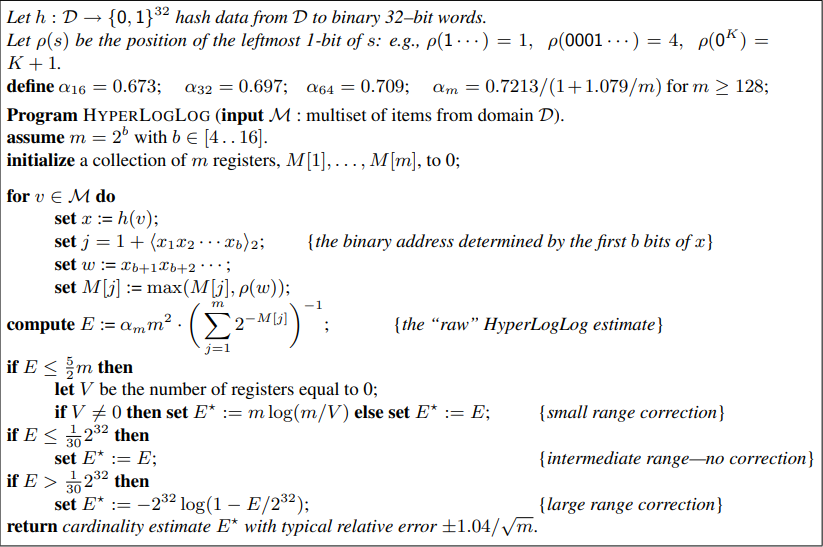

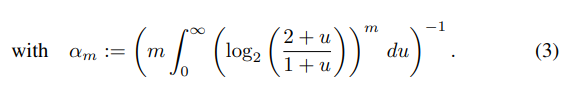

In [31]:
class HyperLogLog:
  def __init__(self, b):
    #в классической реализации из статьи на вход подается 1 параметр - точность b
    #в зависимости от значения вычисляется число регистров
    #также используется 1 хэш-функция, а вероятность коллизий снижается за счет среднего гармонического между регистрами с нормировкой
    self.b = b
    self.m = 1 << b
    self.M = []
    for i in range(self.m):
      self.M.append(0)

  def put(self, s):
    #для общности буду брать только положительные значения (чтобы не завязываться на ведущий -)
    x = mmh3.hash(s, signed = False)
    #[2: из-за того, что битовая строка начинается с 0b
    x = bin(x)[2:].zfill(32)
    j = int(x[:self.b], 2)
    w = x[self.b:]
    r = 1
    #флаг для определения, нашли ли хоть одну ведущую единицу
    find_elem = False
    for i in w:
      if i == '1':
        find_elem = True
        break
      r += 1
    #если получили строку нулей
    if find_elem == False:
      r += 1
    #обновляем значение регистра
    self.M[j] = max(self.M[j], r)

  def est_size(self):
    z = 0.0
    for j in range(self.m):
      z += 2 ** (-self.M[j])
    Z = z ** (-1)
    #для подсчета мультипликативного смещения alpha_m использую функцию quad библиотеки scipy
    #функция выдает tuple значение + ошибка, поэтому использую [0] для получения значения
    #в integrand(x) задам интегрируемую функцию
    if self.m < 128:
      def integrand(x):
        return math.log2((2+x)/(1+x)) ** self.m
      alpha_m = (self.m * quad(integrand, 0, float('+inf'))[0]) ** (-1)
    else:
      alpha_m = 0.7213 / (1 + 1.079 / self.m)
    E = alpha_m * self.m ** 2 * Z
    #также в статье упоминается о нескольких корректировках при маленьких/больших значениях
    if E <= 2.5 * self.m:
      V = 0
      for i in range(self.m):
        if self.M[i] == 0:
          V += 1
      if V > 0:
        E = self.m * math.log(self.m / V)
    elif E > (1.0 / 30.0) * (1 << 32):
      E = - (1 << 32) * math.log(1 - E / (2 << 32))

    return E

В контексте структуры HyperLogLog интересны две ситуации:
1.   Обычный перебор размера строк и параметра точности b для определения тенденции и зависимостей.
2.   Использование нескольких групп уникальности в файлах, чтобы проверить - как ведет себя HyperLogLog, когда не все строки уникальны.

In [49]:
t = Texttable()
precision = [4, 5, 6, 7, 8]
uniqueSetSize = [100, 1000, 10000, 100000]
uniqueGroup = [1, 100, 1000]

for b in precision:
  HLL = HyperLogLog(b)
  for j in uniqueSetSize:
    gen_uniq_seq("hw1_task4_test1.txt", j)
    with open("hw1_task4_test1.txt") as f:
      for line in f:
        HLL.put(line)
    f.close()
    t.add_rows([['prec_param', 'unique_set_size', 'pred_set_size'], [b, j, HLL.est_size()]])
print(t.draw())

+------------+-----------------+---------------+
| prec_param | unique_set_size | pred_set_size |
+============+=================+===============+
| 4          | 100             | 75.138        |
+------------+-----------------+---------------+
| 4          | 1000            | 871.224       |
+------------+-----------------+---------------+
| 4          | 10000           | 22046.136     |
+------------+-----------------+---------------+
| 4          | 100000          | 94758.490     |
+------------+-----------------+---------------+
| 5          | 100             | 94.545        |
+------------+-----------------+---------------+
| 5          | 1000            | 1109.461      |
+------------+-----------------+---------------+
| 5          | 10000           | 10980.018     |
+------------+-----------------+---------------+
| 5          | 100000          | 107528.456    |
+------------+-----------------+---------------+
| 6          | 100             | 118.803       |
+------------+------

In [47]:
t = Texttable()
SizeFile = [1000, 10000, 100000]
UniqueGroup = [1, 100, 1000]
Precision = [4, 5, 6, 7, 8]

for i in SizeFile:
  for j in UniqueGroup:
    gen_grouped_seq("hw1_task4_test2.txt", [(j, int(i / j))])
    for b in Precision:
      HLL = HyperLogLog(b)
      with open("hw1_task4_test2.txt") as f:
        for line in f:
          HLL.put(line)
      f.close()
      t.add_rows([['prec_param', 'total_set_size', 'unique_set_size', 'pred_set_size'], [b, i, j, HLL.est_size()]])
print(t.draw())

+------------+----------------+-----------------+---------------+
| prec_param | total_set_size | unique_set_size | pred_set_size |
+============+================+=================+===============+
| 4          | 1000           | 1               | 1.033         |
+------------+----------------+-----------------+---------------+
| 5          | 1000           | 1               | 1.016         |
+------------+----------------+-----------------+---------------+
| 6          | 1000           | 1               | 1.008         |
+------------+----------------+-----------------+---------------+
| 7          | 1000           | 1               | 1.004         |
+------------+----------------+-----------------+---------------+
| 8          | 1000           | 1               | 1.002         |
+------------+----------------+-----------------+---------------+
| 4          | 1000           | 100             | 88.923        |
+------------+----------------+-----------------+---------------+
| 5       

В обоих случаях алгоритм справляется со своей задачей, и при увеличении числа b, увеличивается число регистров - следовательно, все больше увеличивается точность предсказания (считается, что точность определяется как 1/sqrt(m), где m - число регистров - соответственно, для b=8 ошибка может составить ~6-7%).. Безусловно, здесь есть элемент случайности, поскольку определенное количество выбросов может значительно испортить результат, но в целом тенденция сохраняется.

**Задание 5 - подсчет числа совпадающих ключей при JOIN**

Сначала опишу идею реализации.

Так как речь в условии идет о числе повторений элементов в огромном файле, то буду использовать алгоритм HeavyHitters. Реализацию можно условно поделить на 3 шага:
1.   Реализовать HeavyHitters с одним проходом по первому из файлов. Поскольку нам требуется определить кандидатов на присутствие в 60000+ записях, то использую 166.667 счетчиков (согласно https://en.wikipedia.org/wiki/Misra%E2%80%93Gries_heavy_hitters_algorithm, возьмем k=166.667 при n=10.000.000.000 и 10.000.000.000 / 166.667 ~ 59.999,9). Также известно, что за один проход можно отсеять те элементы, которые точно встречаются меньше, но можно случайно зацепить лишних: тех, кто в реальности встречается менее 60.000 раз.
2.   Сделаю первый проход по второму файлу и буду вести подсчет по тем элементам, которые остались после реализации HeavyHitters (то есть по "подозреваемым" из первого файла). Далее отброшу те элементы, которые во втором файле встречаются менее 60.000 раз. Соответственно, после второго шага у меня останется набор элементов, которые гарантированно встречаются во втором файле 60.000+, а в первом - под подозрением (возможно тоже).
3.   Далее организую второй проход по первому файлу и сделаю подсчет по элементам, оставшимся по результам п.2. Те, которые встречаются более 60.000 раз - и будут теми "проблемными" строками.

Таким образом, если:
*   в первом файле нет ни одной строки с частотой 60.000+, то для ответа хватит одного прохода по одному файлу;
*   во втором файле нет ни одной строки с требуемой частотой (либо есть, но они не совпадают с первой) - в большинстве случаев достаточно по одному проходу по каждому файлу (но могут быть исключения, когда мы в шаге 1 случайно зацепили ложноположительный элемент, и он встречается во втором - тогда нужен второй проход);
*   во всех остальных случаях достаточно двух проходов по первому файлу, и одного прохода по второму.


In [50]:
#сделаю решение универсальным по количеству строк в файле и частоте встречаемости
#по умолчанию значение будет, как в условии - 10.000.000.000 и 60.000
def CountProblemKeys(filename1, filename2, file_len = 10000000000, freq = 60000):

  #рассчитываю число счетчиков в зависимости от входных условий
  counters = math.ceil(file_len / freq)
  #шаг 1 - первый проход первого файла
  #реализация HeavyHitters
  p, c = None, Counter()
  with open(filename1, 'r') as csvfile1:
    csvreader = csv.reader(csvfile1)
    for row in csvreader:
      #работаю только с первой колонкой
      #если элемент есть, увеличиваю счетчик на 1
      if row[0] in c:
        c[row[0]] += 1
      #если элемента еще нет, но словарь не заполнен,
      #добавляю новый элемент
      elif (row[0] not in c) and (len(c) < counters):
        c[row[0]] = 1
      #если элемента нет, и словарь заполнен,
      #уменьшаю все счетчики на 1
      else:
        for i in list(c.keys()):
          c[i] -= 1
          #если счетчик обнулился, освобождаем
          if c[i] == 0:
            del c[i]
  csvfile1.close()
  #если ни один элемент не является подозреваемым, сразу выводим ответ
  if len(c) == 0:
    return c.keys()

  #шаг 2 - первый проход по второму файлу
  #подсчет числа вхождений "подозреваемых" из первого файла во второй
  #предварительно обнуляю все счетчики, так как подсчет будет новый
  for i in c.keys():
    c[i] = 0
  with open(filename2, 'r') as csvfile2:
    csvreader = csv.reader(csvfile2)
    for row in csvreader:
      if row[0] in c:
        c[row[0]] += 1
  #оставляю в словаре только те элементы, которые входят во второй файл 60.000+
  for i in list(c.keys()):
    if c[i] < freq:
      del c[i]
  csvfile2.close()
  #если ни один элемент из п.1 не входит во второй файл 60.000+, сразу даем ответ
  if len(c) == 0:
    return c.keys()

  #шаг 3 - второй проход по первому файлу
  #из оставшихся элементов из п.2 подсчитываю их точное число в первом файле
  for i in c.keys():
    c[i]=0
  with open(filename1, 'r') as csvfile1:
    csvreader = csv.reader(csvfile1)
    for row in csvreader:
      if row[0] in c:
        c[row[0]] += 1
  csvfile1.close()
  #исключаю оставшиеся "ложноположительные" элементы
  for i in list(c.keys()):
    if c[i] < freq:
      del c[i]
  #так как в условии явно не указан формат ответа,
  #верну список ключей с вхождением 60.000+ в оба файла
  return c.keys()

Для тестирования обработаю три основных случая и проверю корректность ответа:
1.   В первом файле нет элементов, которые встречаются достаточное количество раз - функция должна вернуть пустой массив ключей.
2.   В первом файле есть подходящие элементы, но для них нет достаточного количества пар во втором файле - функция должна вернуть пустой массив ключей.
3.   В обоих файлах есть достаточно количество повторений для одних и тех же ключей - функция должна вернуть эти ключи.

Сокращу размер файла и частоту встречаемости строк так, чтобы оставить количество счетчиков (пусть строк будет 10.000.000, а частота - 60) - для ускорения проведения теста (для бОльших данных работать будет аналогично).

In [51]:
gen_uniq_seq("hw1_task5_test1_csv1.csv", 10000000, 1)
gen_uniq_seq("hw1_task5_test1_csv2.csv", 10000000, 1)
print(f'Результат 1 теста: {CountProblemKeys("hw1_task5_test1_csv1.csv", "hw1_task5_test1_csv2.csv", 10000000, 60)}')
gen_grouped_seq("hw1_task5_test2_csv1.csv", [(9000000, 1), (2, 500000)])
print(f'Результат 2 теста: {CountProblemKeys("hw1_task5_test1_csv1.csv", "hw1_task5_test2_csv1.csv", 10000000, 60)}')
print(f'Результат 3 теста: {CountProblemKeys("hw1_task5_test2_csv1.csv", "hw1_task5_test2_csv1.csv", 10000000, 60)}')

Результат 1 теста: dict_keys([])
Результат 2 теста: dict_keys([])
Результат 3 теста: dict_keys(['9000000:dd099380-62a0-4ef6-b1ac-a78cbf863c3b', '9000001:6a023d56-7ee1-42f3-badb-a32dacaa747c'])


Как можно заметить, для всех вышеописанных случаев функция работает корректно. При этом по последнему тесту хотелось бы также отметить, что указанные ключи - с соседними порядковыми номерами (то есть, именно те, которые повторялись по 500000 раз в исходных файлах).

**Задание 6 - подсчет потенциального размера JOIN**

Выскажу свои мысли по поводу реализации. В условии явно разделяются два основных потока: если у нас не так много ключей, и мы можем реализовать точный подсчет; и если ключей очень много, тогда подойдет оценка размера. Ниже рассмотрю каждый вариант в отдельности:
1.   Точный подсчет - поскольку меня по сути интересует количество совпадающих ключей между файлами, использую для подсчета set и буду наполнять его во время прохода по первому файлу. Если после прохода выяснилось, что ключей < миллиона, начну обходить второй файл и наполнять его set (как идея, дополнительно можно использовать BloomFilter, чтобы добавлять в set только те элементы, которые встречаются в BloomFilter, построенном при обходе первого файла). Если в какой-то момент количество ключей в одном из файлов превысило порог, заканчиваю работу с set и перехожу на оценку.
2.   Оценка - параллельно с ведением set веду структуру HyperLogLog на каждый файл. Если в какой-то момент я перешел с точного расчет на оценку, то использую операцию merge для двух HLL - описание нашел, например, https://en.wikipedia.org/wiki/HyperLogLog (для этого реализую несколько вспомогательных методов в классе HyperLogLog). Соответственно, тогда оценка будет считаться по формуле для множеств: P(AUB) = P(A) + P(B) - P(A∩B) => P(A∩B) = P(A) + P(B) - P(AUB), правда с ошибкой e(A∩B) = e(A) + e(B) + e(AUB), но как будто такая оценка будет достаточно точной в сложившихся условиях.

В обоих случаях достаточно 1 прохода по каждому файлу.



In [82]:
class HyperLogLogModify:

  def __init__(self, b):
    self.b = b
    self.m = 1 << b
    self.M = []
    for i in range(self.m):
      self.M.append(0)

  #для реализации merge
  def __iter__(self):
    return iter(self.M)
  def __len__(self):
    return self.m
  def __setitem__(self, i, value):
    self.M[i] = value
  def __getitem__(self, i):
    return self.M[i]

  def put(self, s):
    x = mmh3.hash(s, signed = False)
    x = bin(x)[2:].zfill(32)
    j = int(x[:self.b], 2)
    w = x[self.b:]
    r = 1
    find_elem = False
    for i in w:
      if i == '1':
        find_elem = True
        break
      r += 1
    if find_elem == False:
      r += 1
    self.M[j] = max(self.M[j], r)

  def est_size(self):
    z = 0.0
    for j in range(self.m):
      z += 2 ** (-self.M[j])
    Z = z ** (-1)
    if self.m < 128:
      def integrand(x):
        return math.log2((2+x)/(1+x)) ** self.m
      alpha_m = (self.m * quad(integrand, 0, float('+inf'))[0]) ** (-1)
    else:
      alpha_m = 0.7213 / (1 + 1.079 / self.m)
    E = alpha_m * self.m ** 2 * Z
    if E <= 2.5 * self.m:
      V = 0
      for i in range(self.m):
        if self.M[i] == 0:
          V += 1
      if V > 0:
        E = self.m * math.log(self.m / V)
    elif E > (1.0 / 30.0) * (1 << 32):
      E = - (1 << 32) * math.log(1 - E / (2 << 32))

    return E

In [83]:
def merge(HLL1, HLL2):
  max_len = max(len(HLL1), len(HLL2))
  HLL = HyperLogLogModify(int(math.log2(max_len)))
  for i in range(max_len):
    hll1_reg_i = HLL1[i]
    hll2_reg_i = HLL2[i]
    HLL[i] = max(hll1_reg_i, hll2_reg_i)

  return HLL

In [88]:
def CountJoinSize(filename1, filename2, max_keys = 1000000, max_size_join = 10000000):
  c1, c2 = set(), set()
  #true, если используем точный подсчет
  accCalc = True
  HLL1, HLL2 = HyperLogLogModify(10), HyperLogLogModify(10)
  len1, len2 = 0, 0
  #реализую проход по первому файлу
  with open(filename1, 'r') as csvfile1:
    csvreader1 = csv.reader(csvfile1)
    for row in csvreader1:
      HLL1.put(row[0])
      if accCalc == True:
        #если число ключей добралось до миллиона, заканчиваем точный подсчет
        if len(c1) >= max_keys:
          #переходим на оценку
          accCalc = False
          #очищаем множество
          c1.clear()
        #если текущей ключ уникален, то добавляю в set
        elif row[0] not in c1:
          c1.add(row[0])
  csvfile1.close()
  #реализую проход по второму файлу
  with open(filename2, 'r') as csvfile2:
    csvreader2 = csv.reader(csvfile2)
    for row in csvreader2:
      HLL2.put(row[0])
      if accCalc == True:
        if len(c2) >= max_keys:
          accCalc = False
          c2.clear()
        elif row[0] not in c2:
          c2.add(row[0])
  csvfile2.close()
  answer = 0
  if accCalc == True:
    answer = len(c1 & c2)
    return answer
  #если до сюда дошли, значит - точный подсчет не нужен
  #выполняю merge и подсчитываю с помощью операций с множествами
  #в случае, когда для первого файла заполнены set, буду использовать точное число вместо HLL
  P1, P2 = 0, 0
  if (len(c1) < max_keys and len(c1) > 0):
    P1 = len(c1)
  else:
    P1 = HLL1.est_size()
  answer = P1 + HLL2.est_size() - merge(HLL1, HLL2).est_size()
  return answer

В рамках тестирования проверим основные кейсы, описанные в условии:
1.   Точный подсчет до 1 миллиона уникальных ключей в обоих файлах
2.   Примерный подсчет при достижении хотя бы в одном из файлов 1 миллиона уникальных ключей

Для ускорения тестирования сделаю пропорциональное уменьшение размеров в 10 тысяч раз: файлы будут до 100 миллионов строк, макс. количество уникальных ключей - до 100, размер join - до 1000.


In [89]:
#для теста 1 - сгенерируем два уникальных файла с указанным числом ключей (пересечений не будет)
gen_grouped_seq("hw1_task6_test2_csv1.csv", [(10, 100000)])
gen_grouped_seq("hw1_task6_test2_csv2.csv", [(10, 100000)])
print(f'Результат 1 теста: {CountJoinSize("hw1_task6_test2_csv1.csv", "hw1_task6_test2_csv2.csv", 100, 1000)}')
#для теста 2 - 2 раза полностью уникальный набор строк в файле для оценки
gen_grouped_seq("hw1_task6_test3_csv1.csv", [(1000000, 1)])
print(f'Результат 2 теста: {CountJoinSize("hw1_task6_test3_csv1.csv", "hw1_task6_test3_csv1.csv", 100, 1000)}')

Результат 1 теста: 0
Результат 2 теста: 1014761.3282657211


Как видно из результатов выше, функция отработала верно в обоих случаях: для небольшого числа ключей выдала точный ответ; для большого количества - достаточно точную оценку.